# Develop State-wide Tile Index for DEMs
Rather than maintain the county organization for DEMs, a state-wide tiling system is used. Because the  

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

In [107]:
from shapely.geometry import Polygon
def makegrid(xmin, ymin, xmax, ymax, width=10000, height=10000):
    
    cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), width))
    rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), height))
    rows.reverse()
    
    polygons = []
    for x in cols:
        for y in rows:
            polygons.append(Polygon([(x, y), (x+width, y), (x+width,y+height), (x, y+height)]))
            
    return gpd.GeoDataFrame({'geometry':polygons})

### Divide Counties Into East and West
Each county is assigned to the east or west half of Illinois based on the county centroid's location
relative to the 89w longitude. Counties west of 89w will be processed with EPSG:3444 and counties east
of 89w will be processed with EPSG:3443.

Alternatively, each county could have a preferred projection and tiles could be created in the preferred projection.

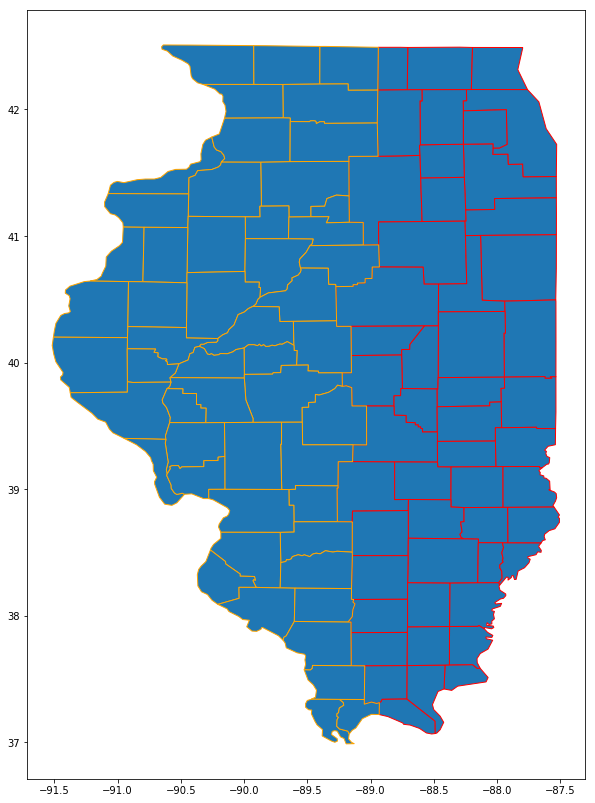

In [108]:
il = gpd.read_file('../examples/IL_Counties.gpkg')

il['mid'] = (il.bounds.maxx+il.bounds.minx)/2 > -89
ax = il[il['mid']].plot(figsize=(10,30), edgecolor='red')
il[~(il['mid'])].plot(ax=ax, edgecolor='orange')
plt.show()

### Create Independent Grids for East and West Illinois
Counties are aggregrated based on the preferred projection and a grid is created uniformally covering 
the spatial extent of the zone. Grid parameters can be customized using *width*, *height*, and *res*. Width
and height are given in pixels, res is given in projection units. Finally, the grid is converted into spatial
tiles and masked against the county boundaries to eliminate superfluous tiles.

To improve downstream processing several additional fields are added including *srs*, *zone*, and *name*. Srs stores the native spatial reference system for the tile. Zone indicates if the tile is associated with the eastern or western half of the state. Name is a unqiue name that includes zone and the first 3 digits of the tiles minx and miny coordinates.

In [109]:
# grid parameters
width = 8192
height = 8192
res = 5

mask = il[il['mid']].to_crs({'init': 'epsg:3443'})
eastgrid = makegrid(*mask.total_bounds, width=width*res, height=height*res)
eastgrid.crs = mask.crs
eastgrid = eastgrid[eastgrid.geometry.intersects(mask.geometry.unary_union)]
eastgrid['srs'] = eastgrid.crs['init'].upper()
eastgrid['zone'] = 'east'
eastgrid['name'] = 'east_'+eastgrid['geometry'].apply(lambda g: str(g.bounds[0])[:3]+'_'+str(g.bounds[1])[:3])

mask = il[~(il['mid'])].to_crs({'init': 'epsg:3444'})
westgrid = makegrid(*mask.total_bounds, width=width*res, height=height*res)
westgrid.crs = mask.crs
westgrid = westgrid[westgrid.geometry.intersects(mask.geometry.unary_union)]
westgrid['srs'] = westgrid.crs['init'].upper()
westgrid['zone'] = 'west'
westgrid['name'] = 'west_'+westgrid['geometry'].apply(lambda g: str(g.bounds[0])[:3]+'_'+str(g.bounds[1])[:3])

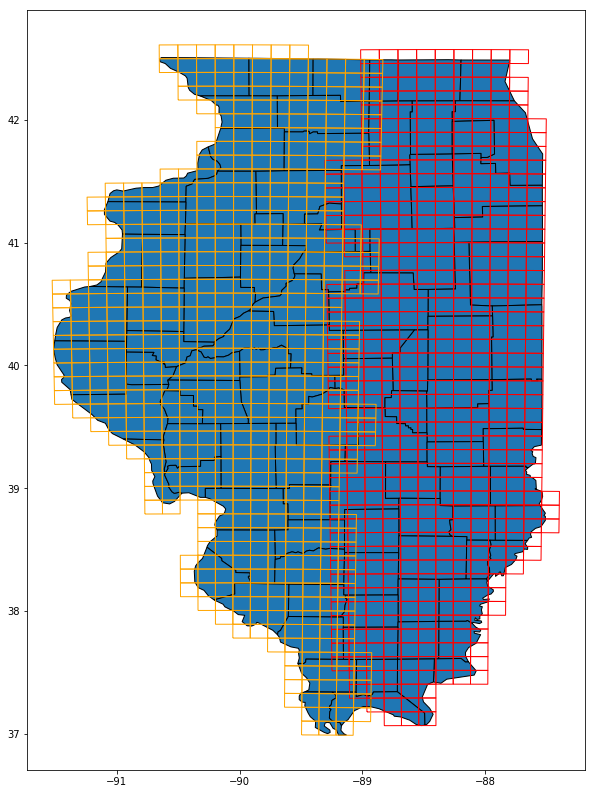

In [110]:
fig, ax = plt.subplots(figsize=(10,30))
il.plot(ax=ax, edgecolor='black')
eastgrid.to_crs(il.crs).plot(ax=ax, facecolor='none', edgecolor='red')
westgrid.to_crs(il.crs).plot(ax=ax, facecolor='none', edgecolor='orange')
plt.show()

### Merge to Create State-wide DEM Tile Index
Finally, save the corridinate system of each tile in the *srs* field, re-project the tiles to a geographic coordinate system
and concatenate tiles into a master DEM tile index.

In [114]:
import pandas as pd

eastgrid = eastgrid.to_crs({'init': 'EPSG:4236'})
westgrid = westgrid.to_crs({'init': 'EPSG:4236'})
tindex = pd.concat([eastgrid, westgrid], ignore_index=True, sort=False)

print(f'Master DEM tindex contains {len(tindex)} tiles.')
tindex.head()

Master DEM tindex contains 1088 tiles.


,geometry,srs,zone,name
0,POLYGON ((-89.29442519763219 41.56450650515664...,EPSG:3443,east,east_719_178
1,POLYGON ((-89.29276436950822 41.45210485851405...,EPSG:3443,east,east_719_174
2,POLYGON ((-89.29111293732947 41.33970092370969...,EPSG:3443,east,east_719_170
3,POLYGON ((-89.28947084013322 41.22729470219819...,EPSG:3443,east,east_719_166
4,POLYGON ((-89.28783801753076 41.11488619546482...,EPSG:3443,east,east_719_161


### Write DEM Tile Index

In [112]:
import os
tindex.to_file('../DEM_tindex.gpkg', driver='GPKG')
print(f'index written: {os.path.getsize("../DEM_tindex.gpkg")} bytes')

index written: 356352 bytes
